In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

### Used dataset is "Mall_Customers" dataset from Kaggle. 

Features selected for clustering:
- `Annual Income (k$)`
- `Spending Score (1-100)`

In [5]:
DFmall = pd.read_csv('Mall_Customers.csv')
print(DFmall.head())
print(DFmall.columns)


   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
Index(['CustomerID', 'Genre', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')


In [3]:
X = DFmall[['Annual Income (k$)', 'Spending Score (1-100)']].values


In [4]:
init_centers = np.array([[40, 60], [70, 20], [90, 80]])


### Running k-means Clustering

We applied the k-means clustering algorithm using the `sklearn` library. Initially, we provided custom cluster centers to observe how the algorithm iteratively improves the clustering.

In [6]:
def plot_my_cluster(kmeans_object, init_centers, iteration):
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    # Scatter plot before clustering
    axes[0].scatter(X[:, 0], X[:, 1], c='g', edgecolor='k', s=150)
    axes[0].scatter(init_centers[:, 0], init_centers[:, 1], c='r', marker='X', s=200, label='Initial Centers')
    axes[0].set_title(f'Original Data (Iteration {iteration})')
    axes[0].set_xlabel('Annual Income (k$)')
    axes[0].set_ylabel('Spending Score (1-100)')
    axes[0].legend()
    
    # Scatter plot after clustering
    axes[1].scatter(X[:, 0], X[:, 1], c=kmeans_object.labels_, cmap='viridis', edgecolor='k', s=150)
    axes[1].scatter(kmeans_object.cluster_centers_[:, 0], kmeans_object.cluster_centers_[:, 1], 
                    c='r', marker='X', s=200, label='Cluster Centers')
    axes[1].set_title(f'Clustered Data (Iteration {iteration})')
    axes[1].set_xlabel('Annual Income (k$)')
    axes[1].set_ylabel('Spending Score (1-100)')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

In [7]:
init_centers

array([[40, 60],
       [70, 20],
       [90, 80]])

In [7]:
# Iterative K-means clustering
for iteration in range(1, 11):
    # Initialize K-means with custom centers and max_iter=1
    kmean = KMeans(n_clusters=3, init=init_centers, max_iter=1, n_init=1, random_state=42)
    kmean.fit(X)



### Visualization

This shows:
- Original data points and initial cluster centers
- Data points assigned to clusters and the updated cluster centers after each iteration

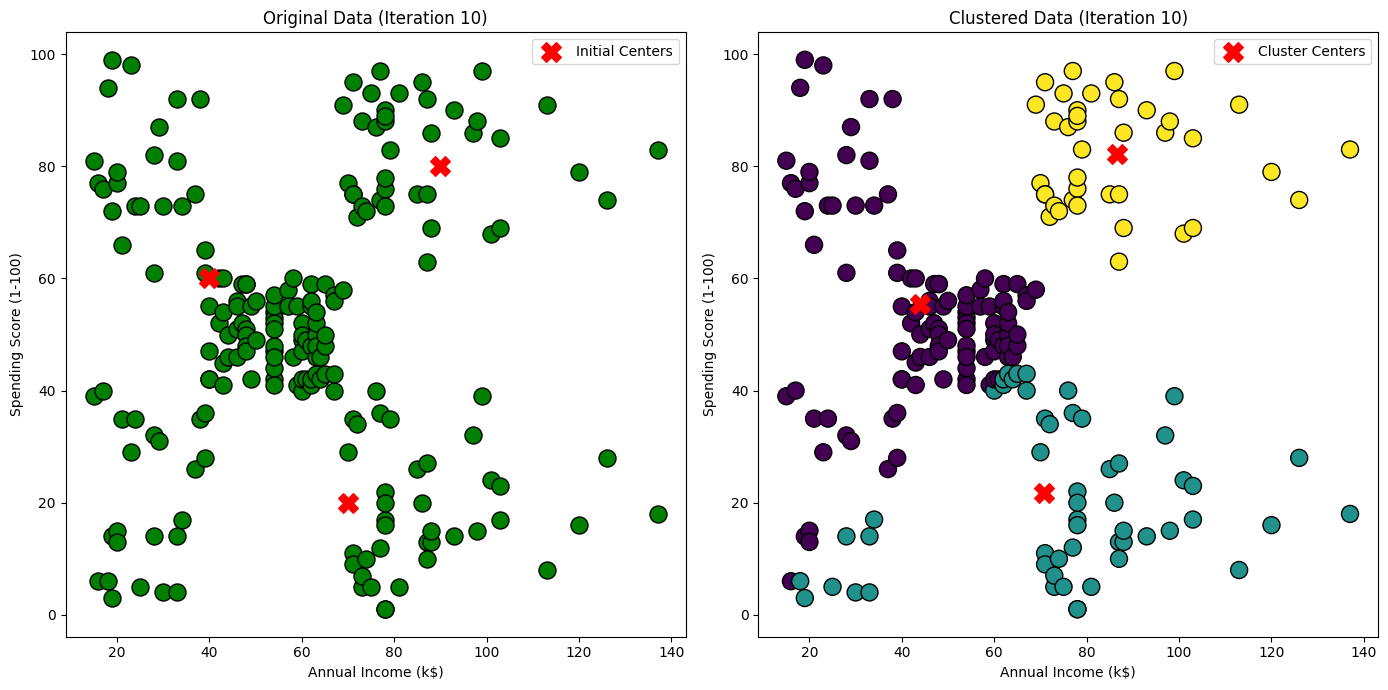

In [8]:
# Plot the clusters
plot_my_cluster(kmean, init_centers, iteration)

In [9]:
init_centers = kmean.cluster_centers_

### Elbow method

Helps determine the optimal number of clusters (\(k\)). It calculates the Within-Cluster Sum of Squares (WCSS) for different values of \(k\).

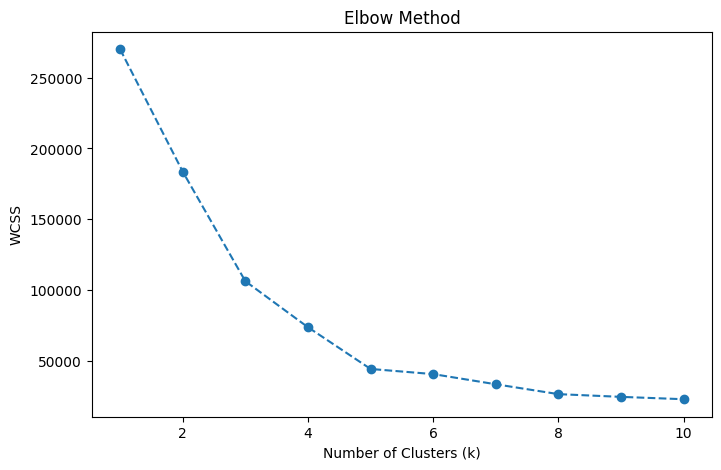

In [10]:
wcss = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot WCSS
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()


### Train/Test split

To understand the effect of different train/test splits, we split the dataset into training (80%) and testing (20%) sets. 

Since k-means is unsupervised, there are no labels to predict. Instead, we:
- Fit k-means on the training data.
- Predicted clusters for the test data.
- Compared cluster centers between training and testing splits to evaluate consistency.

In [11]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80/20 split)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Fit K-means on training data
kmeans_train = KMeans(n_clusters=3, init='k-means++', random_state=42).fit(X_train)

# Predict clusters for test data
train_labels = kmeans_train.predict(X_train)
test_labels = kmeans_train.predict(X_test)

# Compare cluster centers
print("Cluster centers (training):", kmeans_train.cluster_centers_)


Cluster centers (training): [[90.48648649 78.54054054]
 [57.91752577 35.81443299]
 [28.11538462 73.23076923]]


### Computing WCSS for training and test data

In [12]:
def calculate_wcss(X, labels, centers):
    wcss = 0
    for i, center in enumerate(centers):
        cluster_points = X[labels == i]
        wcss += np.sum((cluster_points - center) ** 2)
    return wcss

train_wcss = calculate_wcss(X_train, train_labels, kmeans_train.cluster_centers_)
test_wcss = calculate_wcss(X_test, test_labels, kmeans_train.cluster_centers_)

print(f"WCSS (Training): {train_wcss:.2f}")
print(f"WCSS (Test): {test_wcss:.2f}")

WCSS (Training): 105949.70
WCSS (Test): 24106.30


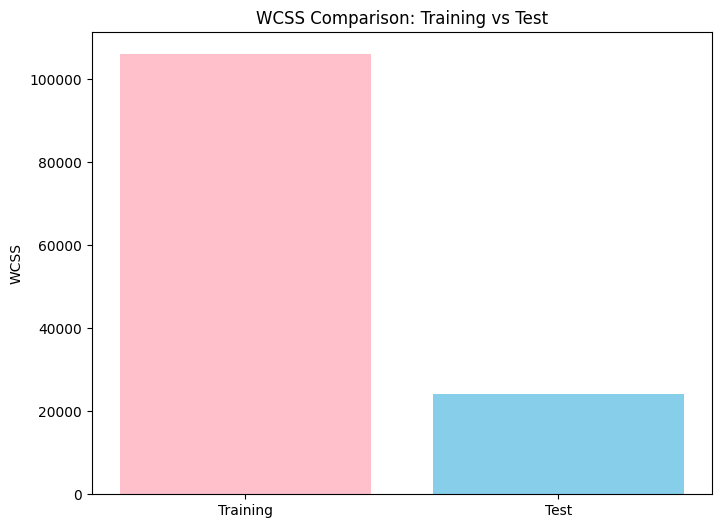

In [13]:
# Visualize WCSS Comparison (Training vs Test)
wcss_values = [train_wcss, test_wcss]
labels = ['Training', 'Test']

plt.figure(figsize=(8, 6))
plt.bar(labels, wcss_values, color=['pink', 'skyblue'])
plt.title('WCSS Comparison: Training vs Test')
plt.ylabel('WCSS')
plt.show()


### Analyzing cluster distribution

In [14]:
def cluster_distribution(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))

train_distribution = cluster_distribution(train_labels)
test_distribution = cluster_distribution(test_labels)

print("Cluster Distribution (Training):", train_distribution)
print("Cluster Distribution (Test):", test_distribution)

Cluster Distribution (Training): {0: 37, 1: 97, 2: 26}
Cluster Distribution (Test): {0: 5, 1: 30, 2: 5}


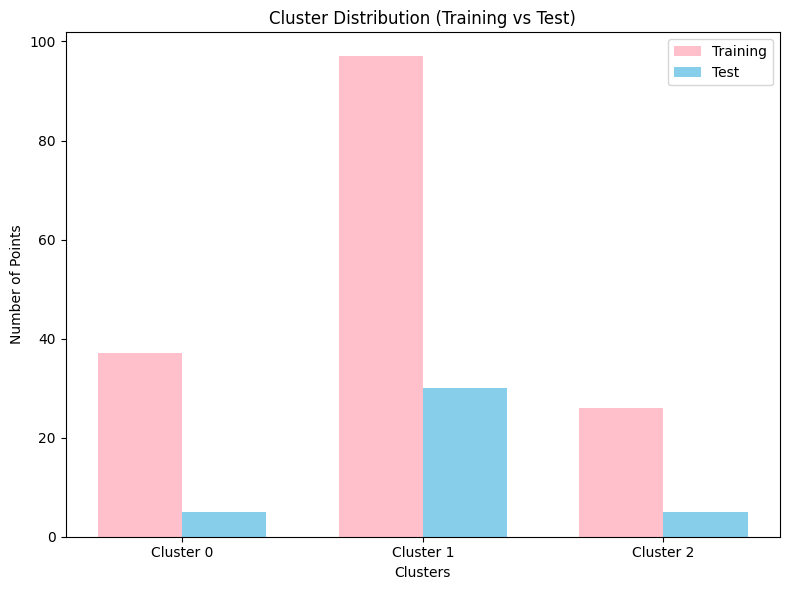

In [15]:
# Bar chart for cluster distribution (Training vs Test)
train_counts = list(train_distribution.values())
test_counts = list(test_distribution.values())

clusters = ['Cluster 0', 'Cluster 1', 'Cluster 2']

x = np.arange(len(clusters))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

rects1 = ax.bar(x - width/2, train_counts, width, label='Training', color='pink')
rects2 = ax.bar(x + width/2, test_counts, width, label='Test', color='skyblue')

ax.set_xlabel('Clusters')
ax.set_ylabel('Number of Points')
ax.set_title('Cluster Distribution (Training vs Test)')
ax.set_xticks(x)
ax.set_xticklabels(clusters)
ax.legend()

plt.tight_layout()
plt.show()

### Experimenting with k-means Parameters

We tested different options of the k-means algorithm to understand their effects:
1. **Initialization (`init`)**:
   - `k-means++`: Default, initializes centers to speed up convergence.
   - `random`: Randomly initializes centers.
2. **Tolerance (`tol`)**:
   - Lower tolerance leads to more precise convergence but might increase computation time.
3. **Inertia**:
   - The Within-Cluster Sum of Squares (WCSS) is used to compare clustering results. Lower inertia indicates tighter clusters.

In [16]:
# Compare K-means with different parameters
kmeans_random = KMeans(n_clusters=3, init='random', random_state=42, n_init=10).fit(X)
kmeans_tol = KMeans(n_clusters=3, init='k-means++', random_state=42, tol=1e-4).fit(X)

# Print inertia for comparison
print("Inertia (default):", kmean.inertia_)
print("Inertia (random init):", kmeans_random.inertia_)
print("Inertia (low tolerance):", kmeans_tol.inertia_)


Inertia (default): 116049.35243700148
Inertia (random init): 106348.37306211119
Inertia (low tolerance): 106348.37306211119
